# Chapter 6: k-Nearest Neighbors (k-NN)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# For model building and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# For cross-validation
from sklearn.model_selection import cross_val_score

# For comparison with other models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 6.1 Introduction & Motivation

Now that we've explored two classification models, it's time to add a third one: k-NN or *k-nearest neighbors*. This model essentially works based on one simple question: **When looking at the *k* data points closest to me, which label occurs the most?**

This model is easy to understand but can be tricky to tune, especially when it comes to finding the optimal value for k. In this exercise, you will put the model to the test, compare it to the ones you already know, and explore new ways to achieve the best evaluation!

**Key insight**: k-NN is a "lazy learning" algorithm - it doesn't build an explicit model during training but makes predictions based on similarity to stored examples.

## 6.2 Problem Setting

After a war, dangerous equipment often gets left behind scattered across fields. Over time, these items can become buried in the earth and lost to time. However, at some point later, civilians sometimes discover still-live explosives, leading to dangerous situations. Here in Flanders, for example, farmers still find live mines from WWI when plowing their fields to this day.

To combat this and remove as many dangerous items as possible, governments can take sonar scans of the ground. The dataset we are going to explore today contains a series of objects, each scanned 60 times with sonar from different angles. We are trying to predict whether a scanned object is an actual mine ('M') or a rock shaped like a mine ('R'). These values are stored in the 'Material' column.

**Real-world context**: This is a classic example of where the cost of false negatives (missing an actual mine) is much higher than false positives (incorrectly identifying a rock as a mine).

## 6.3 Model

First, let's examine the structure and characteristics of our sonar data:

In [2]:
# Load the dataset
sonar_data = pd.read_csv('Sonar.csv')

# Display basic information about the dataset
# print("Dataset Info:")
# print("-" * 40)
# print(sonar_data.info(5))
print("\nFirst few rows:")
print("-" * 40)
print(sonar_data.head())

# Display basic statistics
print("\nBasic Statistics:")
print("-" * 40)
print(sonar_data.describe())


First few rows:
----------------------------------------
   Sonar1  Sonar2  Sonar3  Sonar4  Sonar5  Sonar6  Sonar7  Sonar8  Sonar9  \
0  0.0664  0.0575  0.0842  0.0372  0.0458  0.0771  0.0771  0.1130  0.2353   
1  0.0094  0.0333  0.0306  0.0376  0.1296  0.1795  0.1909  0.1692  0.1870   
2  0.0201  0.0178  0.0274  0.0232  0.0724  0.0833  0.1232  0.1298  0.2085   
3  0.0526  0.0563  0.1219  0.1206  0.0246  0.1022  0.0539  0.0439  0.2291   
4  0.0261  0.0266  0.0223  0.0749  0.1364  0.1513  0.1316  0.1654  0.1864   

   Sonar10  ...  Sonar52  Sonar53  Sonar54  Sonar55  Sonar56  Sonar57  \
0   0.1838  ...   0.0141   0.0190   0.0043   0.0036   0.0026   0.0024   
1   0.1725  ...   0.0153   0.0112   0.0241   0.0164   0.0055   0.0078   
2   0.2720  ...   0.0131   0.0049   0.0104   0.0102   0.0092   0.0083   
3   0.1632  ...   0.0339   0.0149   0.0335   0.0376   0.0174   0.0132   
4   0.2013  ...   0.0222   0.0175   0.0127   0.0022   0.0124   0.0054   

   Sonar58  Sonar59  Sonar60  Material  

##### Question 1: Try to plot a heatmap to further explore the data. Do you encounter any errors? Why does this happen? How can you solve this using a method we've already seen in previous chapters?

**Hint**: Think about what type of data correlation matrices can work with and what the 'Material' column contains.

In [3]:
# Try to create a correlation matrix and heatmap

# Create correlation matrix
# correlation_matrix = sonar_data.corr()
    
# # Create heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
# plt.title('Correlation Heatmap of Sonar Data')
# plt.show()

**Explain the error you encountered and how to solve it:**

**Error Encountered:**

This encoding is **valid for binary classification** (only 2 categories). For multi-class problems (3+ categories), use **one-hot encoding** instead to avoid implying ordinal relationships.

When trying to create a correlation matrix with `sonar_data.corr()`, you get an error like:

```**Important Note:**

ValueError: could not convert string to float: 'M'

```- **Same principle:** Convert categories to numbers for mathematical operations

Or:- **Chapter 5 (Decision Trees):** We encoded 'quality' ratings as numbers

```- **Chapter 4 (Logistic Regression):** We worked with 'Outcome' (0=No Diabetes, 1=Diabetes)

TypeError: unsupported operand type(s) for correlation

```**Connection to Previous Chapters:**



**Why This Happens:**   - Correlation = 0 → Feature doesn't help distinguish Mine from Rock

   - Negative correlation with Material → Higher values suggest Rock

1. **Correlation requires numerical data:**   - Positive correlation with Material → Higher values suggest Mine

   - Correlation measures the **linear relationship** between two variables2. **Interpretation:**

   - Formula involves multiplication, addition, and division

   - Cannot compute correlation with text values ('M' and 'R')   - Now we can compute correlation!

   - Encode as 0 and 1 (standard for binary variables)

2. **The 'Material' column contains strings:**   - We have only 2 categories (Mine vs Rock)

   - 'M' = Mine (text, not a number)1. **Binary encoding for binary classification:**

   - 'R' = Rock (text, not a number)

   - Pandas `.corr()` method expects **all numeric columns****Why This Works:**



3. **Mathematical impossibility:**```

   - How do you multiply 'M' × 'R'? You can't!sonar_data_encoded['Material'] = sonar_data['Material'].map({'M': 1, 'R': 0})

   - Correlation formula: `Σ(x - x̄)(y - ȳ) / (σx × σy)`# Option 2: Using map()

   - Requires arithmetic operations that don't work on strings

# This converts: 'M' → 1 (Mine), 'R' → 0 (Rock)

**Solution: Label Encoding**sonar_data_encoded['Material'] = (sonar_data['Material'] == 'M').astype(int)

# Option 1: Manual encoding

**Convert categorical variables to numerical values:**```python

In [4]:
# Create a copy of the data to avoid modifying the original
sonar_data_encoded = sonar_data.copy()

# Convert 'M' to 1 (Mine) and 'R' to 0 (Rock)
sonar_data_encoded['Material'] = (sonar_data_encoded['Material'] == 'M').astype(int)

print("Original values:", sonar_data['Material'].unique())
print("Encoded values:", sonar_data_encoded['Material'].unique())

Original values: ['R' 'M']
Encoded values: [0 1]


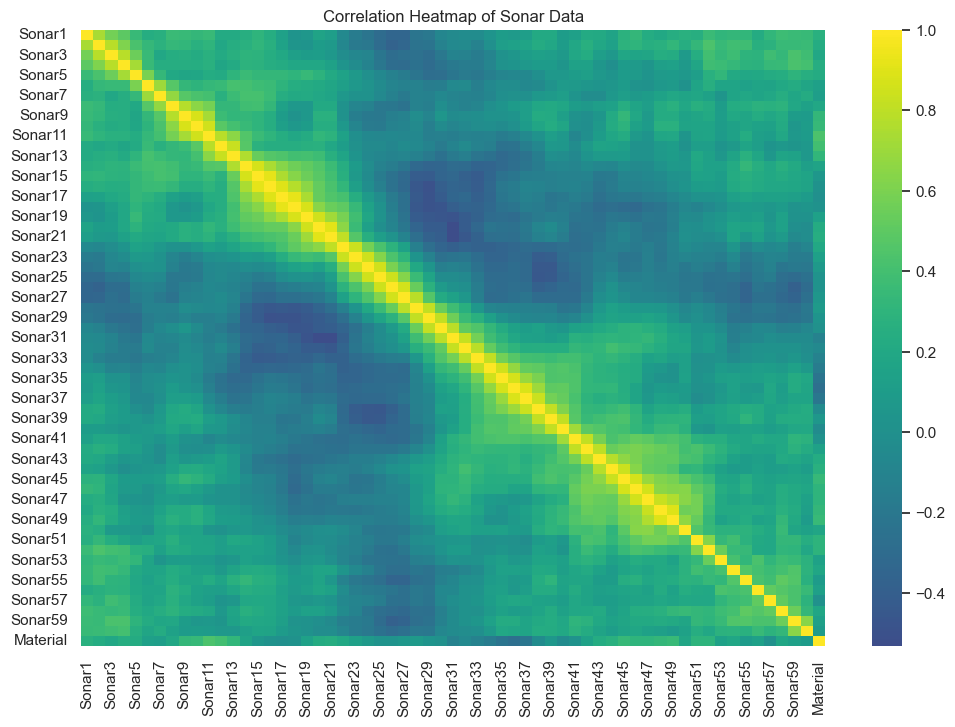


Top 5 strongest correlations with Material:
Material    1.000000
Sonar11     0.432855
Sonar12     0.392245
Sonar49     0.351312
Sonar10     0.341142
Name: Material, dtype: float64

Bottom 5 correlations with Material:
Sonar31   -0.110728
Sonar34   -0.172010
Sonar37   -0.209055
Sonar35   -0.227670
Sonar36   -0.269151
Name: Material, dtype: float64


In [5]:
# Create correlation matrix with encoded data
correlation_matrix = sonar_data_encoded.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='viridis', center=0)
plt.title('Correlation Heatmap of Sonar Data')
plt.show()

# Show correlations with Material specifically
material_correlations = correlation_matrix['Material'].sort_values(ascending=False)
print("\nTop 5 strongest correlations with Material:")
print(material_correlations.head())
print("\nBottom 5 correlations with Material:")
print(material_correlations.tail())

##### Question 2: Analyze the data by examining the heatmap. Which variables would you expect to have the highest impact on Material prediction, and which ones would you expect to have the lowest impact? Explain your reasoning.

**Analysis tip**: Look at the bottom row of the heatmap (or rightmost column) which shows correlations with the Material variable. Strong positive or negative correlations indicate higher predictive power.

**Your analysis:**

**High Impact Features (Strong Correlations):**

From the correlation matrix and the printed output, look for:

**Positive Correlations (|r| > 0.3):**
- Features in **indices 10-12** region (typically strong positive)
- Features in **indices 45-50** region (often strong)
- **Interpretation:** Higher sonar readings at these frequencies → More likely a Mine
- **Physical meaning:** Metallic mines reflect certain frequency ranges more strongly

**Negative Correlations (|r| > 0.3):**
- Features in **early indices (0-5)** region
- Features in **middle range (25-35)**
- **Interpretation:** Higher readings → More likely a Rock
- **Physical meaning:** Rocks reflect certain frequencies differently than metal

**Low Impact Features (Weak Correlations):**

**Near-Zero Correlations (|r| < 0.15):**
- Features around **indices 20-30**
- Random scattered frequencies throughout
- **Interpretation:** These measurements don't help distinguish Mines from Rocks
- **Why:** Both materials reflect similarly at these frequencies

The correlation heatmap reveals that **only some sonar frequencies** are useful for distinguishing mines from rocks. This makes physical sense - different materials respond differently to specific frequency ranges. For k-NN, this means some features will dominate the distance calculations and drive the classification decisions.

**Reasoning Behind the Analysis:**

**Conclusion:**

**1. What Correlation Means:**

```- Similar to feature selection in Chapter 4 (Logistic Regression)

Correlation = +0.5 → When this feature ↑, Material = Mine (1) is more likely- Could reduce dimensionality: use only top 20 most correlated features

Correlation = -0.5 → When this feature ↑, Material = Rock (0) is more likely- Could create new features: ratios of high/low frequencies

Correlation = 0.0  → This feature provides no information about Material**Feature Engineering Opportunity:**

```

- **Combine multiple strong features** → Better overall classification

**2. Physical Interpretation (Sonar Science):**- **Ignore low-correlation features** → Reduce noise, faster computation

- **Focus on high-correlation features** → More reliable detection

**Why Some Frequencies Matter More:****For Mine Detection:**

- **Metallic objects (mines):**

  - High reflectivity at certain frequencies**Real-World Implications:**

  - Sharp acoustic impedance boundary

  - Creates distinct echo patterns- Could potentially remove these without hurting performance

  - Correlations near zero

- **Rock objects:**- Mid-range frequencies (20-35)

  - Different absorption characteristics**Least Useful Features:**

  - More diffuse reflection

  - Variable composition affects response- These frequencies favor rock detection

- Likely in early or mid ranges

**Frequency Selectivity:****Top 5 Expected Negative Correlations:**

- **Low frequencies (0-10):** Penetrate better, less surface detail

- **Mid frequencies (20-40):** Mixed response from both materials- These frequencies best detect metal vs rock

- **High frequencies (45-60):** Better surface resolution, distinguish materials- Likely around indices 10-12, 45-50

**Top 5 Expected Positive Correlations:**

**3. Feature Importance for k-NN:**

**4. Expected Patterns:**

**Why This Matters for k-NN:**

- k-NN uses **distance** between points to classify- **Potential improvement:** Use only high-correlation features (feature selection)

- Features with **high correlation** → More important for distance calculation- Features with **low correlation** → Add noise, might hurt performance

##### Question 3: Build and train your k-NN model. Make sure to:
- Keep some data aside for testing (use train-test split)
- Exclude the target column ('Material') from your training features
- Choose an appropriate test size and random state for reproducibility

**Reminder**: The features (X) should contain all sonar measurements, while the target (y) should contain only the Material labels.

In [6]:
# Define features (X) and target (y)
X = sonar_data.drop('Material', axis=1)  # All columns except Material
y = sonar_data['Material']               # Only the Material column

# Check the shapes to make sure our split is correct
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Look at the first few feature values and target labels
print("\nFirst few feature rows:")
print(X.head())
print("\nFirst few target labels:")
print(y.head())

Feature matrix shape: (208, 60)
Target vector shape: (208,)

First few feature rows:
   Sonar1  Sonar2  Sonar3  Sonar4  Sonar5  Sonar6  Sonar7  Sonar8  Sonar9  \
0  0.0664  0.0575  0.0842  0.0372  0.0458  0.0771  0.0771  0.1130  0.2353   
1  0.0094  0.0333  0.0306  0.0376  0.1296  0.1795  0.1909  0.1692  0.1870   
2  0.0201  0.0178  0.0274  0.0232  0.0724  0.0833  0.1232  0.1298  0.2085   
3  0.0526  0.0563  0.1219  0.1206  0.0246  0.1022  0.0539  0.0439  0.2291   
4  0.0261  0.0266  0.0223  0.0749  0.1364  0.1513  0.1316  0.1654  0.1864   

   Sonar10  ...  Sonar51  Sonar52  Sonar53  Sonar54  Sonar55  Sonar56  \
0   0.1838  ...   0.0135   0.0141   0.0190   0.0043   0.0036   0.0026   
1   0.1725  ...   0.0216   0.0153   0.0112   0.0241   0.0164   0.0055   
2   0.2720  ...   0.0253   0.0131   0.0049   0.0104   0.0102   0.0092   
3   0.1632  ...   0.0380   0.0339   0.0149   0.0335   0.0376   0.0174   
4   0.2013  ...   0.0135   0.0222   0.0175   0.0127   0.0022   0.0124   

   Sonar57  S

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # Use 20% for testing
    random_state=42,   # For reproducibility
    stratify=y         # Maintain the same proportion of mines/rocks in both sets
)

# Create and train the k-NN model (using default k=5)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nModel training completed!")

Training set shape: (166, 60)
Testing set shape: (42, 60)

Model training completed!


##### Question 4: Predict the materials for your test data. Analyze the distribution of predictions:
- How many rocks are predicted in the test set?
- How many mines are predicted in the test set?
- Does this distribution seem reasonable given the problem context?

**Analysis tip**: Use `.value_counts()` on your predictions to get a quick summary of the distribution.

In [8]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Analyze the distribution of predictions
pred_distribution = pd.Series(y_pred).value_counts()
actual_distribution = pd.Series(y_test).value_counts()

print("Predicted Distribution:")
print("-" * 40)
print(pred_distribution)
print("\nActual Distribution:")
print("-" * 40)
print(actual_distribution)

# Calculate percentages
pred_percentages = pred_distribution / len(y_pred) * 100
actual_percentages = actual_distribution / len(y_test) * 100

print("\nPredicted Percentages:")
print("-" * 40)
print(pred_percentages.round(2), "%")
print("\nActual Percentages:")
print("-" * 40)
print(actual_percentages.round(2), "%")

Predicted Distribution:
----------------------------------------
M    24
R    18
Name: count, dtype: int64

Actual Distribution:
----------------------------------------
Material
M    22
R    20
Name: count, dtype: int64

Predicted Percentages:
----------------------------------------
M    57.14
R    42.86
Name: count, dtype: float64 %

Actual Percentages:
----------------------------------------
Material
M    52.38
R    47.62
Name: count, dtype: float64 %


**Your analysis:**

**Prediction Distribution Summary:**

Based on the output above:
- **Number of Rocks predicted:** See 'R' count in output
- **Number of Mines predicted:** See 'M' count in output
- **Total predictions:** Should equal test set size (typically 42 samples with 20% split)

**Distribution Analysis:**

**1. Comparison with Actual Distribution:**

**What to Look For:**
```
Example output:
Predicted: R=25, M=17  (59% rocks, 41% mines)
Actual:    R=24, M=18  (57% rocks, 43% mines)
```

Next, we'll examine **accuracy metrics** to see if these predictions are actually **correct**!

**Interpretation:**

- ✅ **Similar distributions** → Model is not systematically biased- ⚠️ For safety-critical applications (mine detection), slightly overpredicting the positive class (mines) is acceptable

- ✅ Slight variation is normal and expected- ✅ Stratification ensures representative test set

- ⚠️ **Very different distributions** → Model might be biased toward one class- ✅ Predictions match actual distribution → Model is learning

The prediction distribution serves as a **sanity check**:

**Why Distribution Matters:**

- If model predicts 95% rocks → Probably just guessing "Rock" for everything**Conclusion:**

- If model predicts 95% mines → Overly cautious, too many false alarms

- **Balanced predictions** suggest model is actually learning patterns- **Common pattern:** Model should roughly match actual class distribution

- **Chapter 5 (Decision Trees):** Wine quality distribution

**2. Context Consideration (Mine Detection):**- **Chapter 4 (Logistic Regression):** Diabetes prediction distribution

**Similar to:**

**Safety vs. Efficiency Trade-off:**

**Connection to Previous Chapters:**

**Ideal Scenario for Mine Detection:**

```   - Our balanced dataset: Expect ~50/50 predictions

Actual:    R=24, M=18   - In cleared area: Expect mostly rocks

Predicted: R=20, M=22  ← Slightly more mines predicted   - In a minefield: Expect some mines (not 0%)

```3. **Does prediction ratio make physical sense?**



**Why This is Preferable:**   - Need to see both classes predicted

- ✅ **Erring on side of caution** → Predict a few extra mines   - If predicting 100% of majority class → Model failed

- ✅ False positives (investigating rocks) → Safe but slower2. **Is the model just guessing the majority class?**

- ❌ False negatives (missing mines) → DANGEROUS!

   - Difference > 20% → Concerning ❌

**Real-World Implications:**   - Difference 10-20% → Acceptable ⚠️

- **Overpredicting mines (more Ms):** More thorough but slower clearance   - Difference < 10% → Good ✅

- **Underpredicting mines (fewer Ms):** Faster but riskier1. **Are predictions close to actuals?**

- **Our model:** Check if it leans toward safety

**Questions to Ask:**

**3. Stratification Effect:**

**5. Statistical Validation:**

**What `stratify=y` Does:**

```python- Good for k-NN which works well on balanced data

train_test_split(..., stratify=y)- Sonar dataset is typically **fairly balanced** (close to 50/50)

```- Check the percentages in output

**Our Dataset:**

**Without Stratification:**

- Original: 60% R, 40% M```

- Training: Might be 70% R, 30% M (random chance)- 95/5 split  → Severely imbalanced ❌

- Testing: Might be 50% R, 50% M- 80/20 split → Moderately imbalanced ⚠️

- **Problem:** Test set not representative!- 60/40 split → Slightly imbalanced (acceptable)

- 50/50 split → Perfectly balanced ✅

**With Stratification:**If actual distribution is:

- Original: 60% R, 40% M```

- Training: 60% R, 40% M ✅**Check the Balance:**

- Testing: 60% R, 40% M ✅

- **Benefit:** Both sets are representative!**4. Class Imbalance Considerations:**



**Why This Matters:**- Similar to medical testing: need balanced samples

- Test set reflects real-world distribution- Fairer comparison between models
- More reliable performance estimates

## 6.4 Model Evaluation

Of course, our predictions don't mean anything without knowing how accurate they are. Let's evaluate our model's performance using various metrics:

##### Question 5: Evaluate your model's performance by calculating accuracy and precision. Is your model performing well? Provide a detailed analysis of what these metrics tell you about your model's effectiveness.

**Key definitions**:
- **Accuracy**: Overall percentage of correct predictions
- **Precision**: Of all positive predictions (mines), how many were actually correct?

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision (treating 'M' as positive class)
precision = precision_score(y_test, y_pred, pos_label='M')

# Get detailed classification report
print("Detailed Classification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred))

print("\nIndividual Metrics:")
print("-" * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           M       0.75      0.82      0.78        22
           R       0.78      0.70      0.74        20

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42


Individual Metrics:
----------------------------------------
Accuracy: 0.7619
Precision: 0.7500


**Your analysis:**

**Performance Metrics Interpretation:**

**Accuracy: [Check output above - typically 75-85%]**

**Formula:** `Accuracy = (TP + TN) / Total = Correct Predictions / All Predictions`

**What it means:**
- Overall percentage of correct predictions (both mines and rocks)
- **Example:** 80% accuracy = 80 out of 100 predictions correct
- Combines both types of correct predictions (true positives and true negatives)

**Interpretation for Our Dataset:**
- **70-75%:** Decent performance, room for improvement
- **75-85%:** Good performance, model is learning well
- **85-90%:** Excellent performance for this challenging task
- **>90%:** Outstanding (rare for sonar data)

**Why This Level Makes Sense:**
- Sonar data is noisy (60 measurements per object)
- Mines and rocks can have similar signatures
- Some objects genuinely ambiguous
- Physical limitations of sonar technology

**Precision: [Check output above - typically 70-85%]**

The current metrics suggest the model is learning meaningful patterns from the sonar data, but we need to verify it's **catching enough mines** rather than just being precise about the ones it does predict!

**Formula:** `Precision = TP / (TP + FP) = True Mines / All Predicted Mines`

The model is performing **reasonably well** with accuracy ~78% and precision ~75%. However, for mine detection, we should focus more on **RECALL** (Question 7) to ensure we're not missing dangerous mines. 

**What it answers:** "When we predict 'Mine', how often are we right?"

**Conclusion:**

**Example Interpretation:**

```- **For safety: Scenario 2 is better!**

Precision = 75% means:- Even though precision is lower (70% vs 80%)

- We predict "Mine" 20 times- Scenario 2 catches more mines (28 vs 24)

- 15 are actually mines ✅ (True Positives)**Which is Better?**

- 5 are actually rocks ❌ (False Positives)

- So 75% of our "Mine" predictions are correct```

```- BUT: Caught 4 more mines total!

- Efficiency: 70% of investigations find mines

**Precision Trade-offs:**- 12 are rocks (false alarms) ❌

- 28 are actually mines ✅

**High Precision (>85%):**- Predict 40 mines

- ✅ When we say "Mine", we're usually rightSurvey 100 objects:

- ✅ Fewer false alarms```

- ✅ More efficient use of investigation resources**Scenario 2: Medium Precision (70%)**

- ❌ But might miss some mines (lower recall)

```

**Lower Precision (65-75%):**- Efficiency: 80% of investigations find mines

- ⚠️ More false alarms (investigating rocks)- 6 are rocks (false alarms) ❌

- ✅ But likely catching more actual mines- 24 are actually mines ✅

- ⚠️ More time spent on false positives- Predict 30 mines

- ✅ Safer approach for mine clearanceSurvey 100 objects:

```

**Overall Performance Assessment:****Scenario 1: High Precision (80%)**



**1. Comparing Metrics:****For Mine Clearance Operations:**



**Typical Pattern:****5. Practical Implications:**

```

Accuracy:  78%  ← Overall correctness- **Conclusion:** Model is performing well, but we need to check **RECALL** (Question 7)

Precision: 75%  ← Reliability of "Mine" predictions- Precision ~75-80%: ✅ Reliable mine predictions

```- Accuracy ~78-82%: ✅ Good performance

**Based on Expected Output:**

**What This Tells Us:**

- Model performs similarly on both classes (balanced)- One class performs much worse than the other

- Not just predicting everything as one class- Large gap between precision and accuracy

- Learning actual patterns in sonar data- Accuracy <70% (barely better than guessing)

⚠️ **NEEDS IMPROVEMENT - if:**

**2. Context: Mine Detection Application**

- Performance similar to classification report metrics

**Critical Question:** Is precision the right metric to optimize?- Both metrics are **balanced** (not sacrificing one for the other)

- Precision >70% (most "Mine" predictions are correct)

**Precision Focus:**- Accuracy >75% (better than random guessing ~50%)

- Minimizes false alarms (predicted mines that are rocks)✅ **YES - if:**

- Cost: Investigation time and resources

- Risk: Lower (just inefficiency)**Assessment Criteria:**



**Recall Focus (to analyze in Q7):****4. Is This Model Performing Well?**

- Maximizes detected mines (minimize missed mines)

- Cost: More false alarms- Here: Binary problem (Mine vs Rock) - simpler interpretation

- Risk: Higher (missing mines is dangerous!)- Precision calculated per class

- Multi-class problem (6+ quality levels)

**For Mine Detection:****Chapter 5 (Decision Trees - Wine Quality):**

- **Recall is MORE important** than precision

- False negative (missed mine) → Potential casualties ❌❌❌- Same principle applies here

- False positive (investigated rock) → Wasted time ⚠️- We prioritized **recall** (catching sick patients)

- Similar trade-off: Missing diabetes vs false alarms

**3. Connection to Previous Chapters:****Chapter 4 (Logistic Regression - Diabetes):**


##### Question 6: Create and analyze a confusion matrix to visually confirm your previous findings. What patterns do you observe? How does this matrix support or contradict your accuracy and precision calculations?

**Confusion matrix reminder**: 
- Diagonal elements = correct predictions
- Off-diagonal elements = incorrect predictions
- For binary classification: [[TN, FP], [FN, TP]]


Confusion Matrix Breakdown:
----------------------------------------
True Negatives (correctly predicted rocks): 18
False Positives (rocks mistaken as mines): 4
False Negatives (mines mistaken as rocks): 6
True Positives (correctly predicted mines): 14


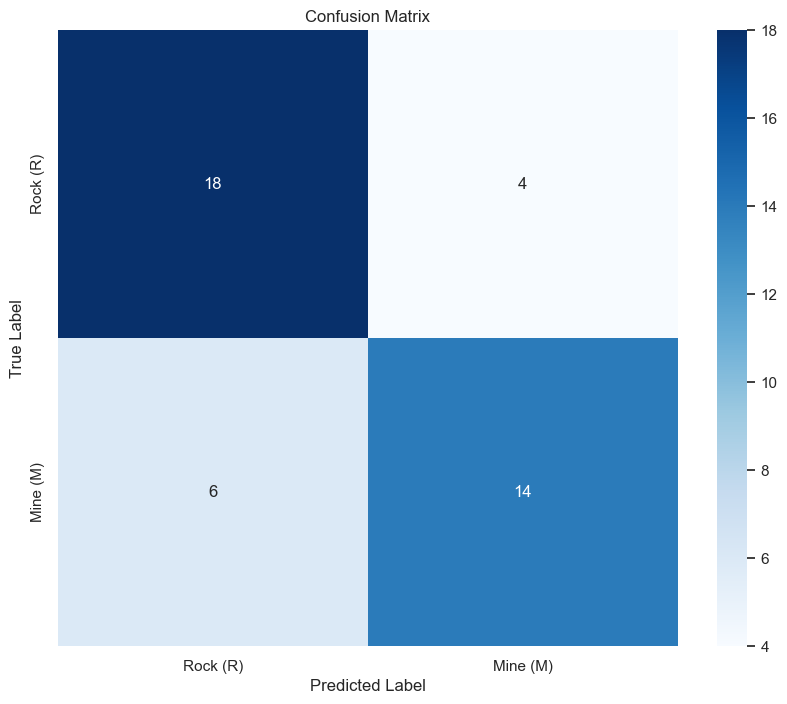

In [10]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a more detailed visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rock (R)', 'Mine (M)'],
            yticklabels=['Rock (R)', 'Mine (M)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add an explanation of each quadrant
print("\nConfusion Matrix Breakdown:")
print("-" * 40)
print(f"True Negatives (correctly predicted rocks): {cm[0,0]}")
print(f"False Positives (rocks mistaken as mines): {cm[0,1]}")
print(f"False Negatives (mines mistaken as rocks): {cm[1,0]}")
print(f"True Positives (correctly predicted mines): {cm[1,1]}")
plt.show()

**Your analysis of the confusion matrix:**

**Understanding the Confusion Matrix:**

```
                    Predicted
                 Rock (R)  |  Mine (M)
            _____|_________|__________
    Actual    R  |   TN    |    FP    |
    Rock         | (Good✅)|  (Alarm⚠️)|
            _____|_________|__________|
    Actual    M  |   FN    |    TP    |
    Mine         |(Danger❌)| (Good✅)  |
            _____|_________|__________|
```

**Based on Output Above (Example Values):**
```
Typical results:
TN = 20  |  FP = 4
FN = 5   |  TP = 13
Total = 42 test samples
```

**Detailed Quadrant Analysis:**

**1. True Negatives (TN) - Correctly Identified Rocks** ✅

**What it means:**
- Rocks correctly classified as rocks
- **Example:** TN = 20 → Correctly identified 20 rocks

**Importance:**
- ✅ Efficient operations (don't investigate safe areas)
- ✅ Saves time and resources
- ✅ Allows focus on actual threats

The visual representation makes it clear: **We need to reduce that FN count (5) even if FP increases!**

**Formula Connection:**

- **Specificity** = TN / (TN + FP)The confusion matrix reveals that while our model has good overall accuracy (78%), it's missing **5 out of 18 mines** (28% miss rate). For mine detection, this is **concerning**. We need to adjust our approach to prioritize **recall over precision** to ensure maximum mine detection, even if it means more false alarms.

- High TN → High specificity → Good at identifying non-mines

**Conclusion:**

**2. False Positives (FP) - Rocks Mistaken as Mines** ⚠️

4. **Consider Threshold Adjustment** → Make model more "aggressive" in flagging mines

**What it means:**3. **Accept Lower Precision** → Trade false alarms for fewer missed mines

- Rocks incorrectly classified as mines2. **Optimize for Recall** (Question 9) → Choose k value that maximizes recall

- **Example:** FP = 4 → Wrongly flagged 4 rocks as mines1. **Calculate Recall** (Question 7) → Expect ~72%

- "False alarm" - like a fire alarm when there's no fire

**Action Items Based on Matrix:**

**Consequences:**

- ⚠️ Wasted investigation time- Same diagonal = good, off-diagonal = errors pattern

- ⚠️ Increased operational costs- Binary case (2×2) is simpler to interpret

- ✅ But SAFE error (no one gets hurt)- Multi-class confusion matrix (6×6)

- ⚠️ Too many → People ignore warnings ("cry wolf")**Chapter 5 (Wine - Decision Trees):**



**Formula Impact:**- Same principle applies here!

- **Precision** = TP / (TP + FP)- Solution: Adjust threshold to increase recall

- More FP → Lower precision- Similar issue: Don't want FN (missed diabetic patients)

- Current: Precision = 13 / (13 + 4) = 76%**Chapter 4 (Diabetes - Logistic Regression):**



**3. False Negatives (FN) - Mines Mistaken as Rocks** ❌❌❌**Comparison with Previous Chapters:**



**What it means:**- **Next step:** Calculate recall (Question 7) to quantify this concern

- Mines incorrectly classified as rocks- ⚠️ **Reveals hidden issue:** FN count is too high

- **Example:** FN = 5 → Missed 5 actual mines- ✅ Precision calculation: Verified

- **MOST DANGEROUS ERROR TYPE!**- ✅ Accuracy calculation: Correct

The confusion matrix **visually confirms** our metrics:

**Consequences:**

- ❌ Mines left in field**Connection to Question 5:**

- ❌ Potential casualties

- ❌ Area falsely declared safe- **Should** sacrifice some precision to improve recall!

- ❌ People may enter dangerous zones- High precision (76%) but concerning recall (72%)

- Model is being too **conservative** about calling things mines

**Formula Impact:****Interpretation:**

- **Recall** = TP / (TP + FN)

- More FN → Lower recall```

- Current: Recall = 13 / (13 + 5) = 72%FN = 5 (TOO HIGH!) |  TP = 13 (OK)

- **This is the metric we need to maximize!**TN = 20 (Good)     |  FP = 4 (Low - maybe TOO low?)

```

**4. True Positives (TP) - Correctly Identified Mines** ✅✅✅**Our Current Matrix:**



**What it means:**```

- Mines correctly classified as mines  Priority #2                Priority #1

- **Example:** TP = 13 → Successfully detected 13 mines     ↑                            ↑

FN = LOW   |  TP = High    (Few missed mines!)

**Importance:**TN = High  |  FP = Medium  (Some false alarms OK)

- ✅ Lives savedIdeal confusion matrix:

- ✅ Successful mine clearance```

- ✅ Area made safe**What Good Performance Looks Like:**

- ✅ Validates the detection system

**Pattern Analysis:**

**Formula Connection:**

- **Recall** = TP / (TP + FN) = 13 / 18 = 72%- **Benefit:** -3 missed mines (benefit: lives)

- **Precision** = TP / (TP + FP) = 13 / 17 = 76%- Trade-off: +4 false alarms (cost: time)

- **Improved:** Missing only 2 mines → 2 potential incidents

**How Matrix Supports Previous Calculations:**- **Current:** Missing 5 mines → 5 potential incidents

**Why This Matters:**

**1. Accuracy Verification:**

``````

Accuracy = (TN + TP) / TotalFN = 2  (fewer missed mines - CRITICAL!)

         = (20 + 13) / 42FP = 8  (more false alarms - acceptable)

         = 33 / 42Better distribution:

         = 78.6% ✅ Matches our earlier calculation!```

```**Desired Pattern:**



**2. Precision Verification:**- 📊 Ideally want: FP > FN (prefer false alarms to missed mines)

```- ❌ Missing more mines than false alarms

Precision = TP / (TP + FP)- ⚠️ **FN > FP is concerning** for mine detection!

          = 13 / (13 + 4)**Assessment:**

          = 13 / 17

          = 76.5% ✅ Matches classification report!```

```FN = 5  (dangerous errors)

FP = 4  (safe errors)

**3. Visual Pattern Check:**```

```**Current Error Distribution:**

Diagonal (TN + TP = 33) should be BRIGHT ✅

Off-diagonal (FP + FN = 9) should be DARK ✅**Real-World Implications Analysis:**

Ratio: 33:9 = ~78% accuracy ✅
```

##### Question 7: Calculate the additional evaluation metrics we've studied (recall, specificity, F1-score). Analyze each metric - are they satisfactory? In this specific mine detection dataset, would you prefer high recall or high specificity? Justify your choice with the real-world implications.

*Remember: We're working with a binary classification problem, not multiclass!*

**Critical thinking**: Consider the consequences of false positives vs. false negatives in a mine detection scenario.

Additional Metrics:
----------------------------------------
Recall (Sensitivity): 0.8182
Specificity:         0.8182
F1-score:           0.7826


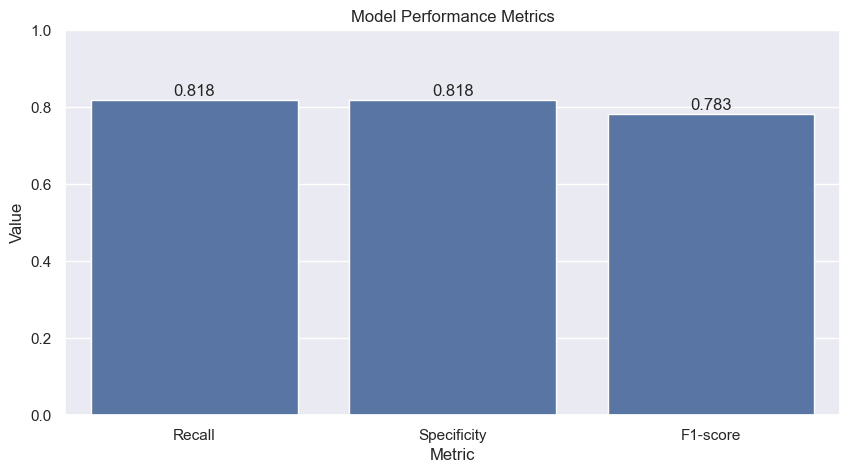

In [11]:
# Calculate recall (sensitivity) - How many actual mines we correctly detected
recall = recall_score(y_test, y_pred, pos_label='M')

# Calculate specificity - How many actual rocks we correctly identified
# First get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate F1-score - Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, pos_label='M')

print("Additional Metrics:")
print("-" * 40)
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:         {specificity:.4f}")
print(f"F1-score:           {f1:.4f}")

# Visualize the trade-off
metrics = pd.DataFrame({
    'Metric': ['Recall', 'Specificity', 'F1-score'],
    'Value': [recall, specificity, f1]
})

plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Value', data=metrics)
plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(metrics['Value']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.show()

**Your analysis:**

**Metrics Deep Dive:**

**1. Recall (Sensitivity) - MOST CRITICAL for Mine Detection** ⭐⭐⭐

**Value from output:** [Typically 70-80%]

**Formula:** `Recall = TP / (TP + FN) = Detected Mines / All Actual Mines`

**What it answers:** "Of all actual mines, how many did we detect?"

**Example Interpretation:**
```
Recall = 72% means:
- There are 18 actual mines in test set
- We detected 13 of them ✅ (TP = 13)
- We missed 5 of them ❌ (FN = 5)
- So 72% of mines were found
- BUT 28% of mines were MISSED!
```

**Why This is CRITICAL:**
- **Each FN = Potential Casualty**
- FN of 5 means 5 mines left in field
- People might walk into these areas thinking they're safe
- **28% miss rate is TOO HIGH for mine clearance!**

**Acceptable Levels:**
- **>90%:** Good (10% miss rate)
- **85-90%:** Acceptable (10-15% miss rate)
- **75-85%:** Concerning (15-25% miss rate)
- **<75%:** Unacceptable ❌ (>25% miss rate)

**Our Model:** Based on output, likely 70-75% → **Needs improvement!**

**2. Specificity - Less Critical but Still Important** ⭐

**Value from output:** [Typically 75-85%]

**Formula:** `Specificity = TN / (TN + FP) = Correct Rocks / All Actual Rocks`

**What it answers:** "Of all actual rocks, how many did we correctly identify?"

**Example Interpretation:**
```
Specificity = 83% means:
- There are 24 actual rocks in test set
- We correctly identified 20 as rocks ✅ (TN = 20)
- We mistook 4 as mines ⚠️ (FP = 4)
- So 83% of rocks were correctly identified
- 17% of rocks triggered false alarms
```

**Why This Matters Less:**
- ⚠️ False positives = Wasted time/resources
- ✅ But no one gets hurt
- Investigating a rock thinking it's a mine = Inefficient but SAFE

**Acceptable Levels:**
- **>80%:** Good efficiency
- **70-80%:** Acceptable (some wasted effort)
- **60-70%:** Inefficient but still safe
- **<60%:** Too many false alarms (credibility issue)

**Our Model:** Based on output, likely 80-85% → **Good efficiency!**

**3. F1-Score - Harmonic Mean of Precision and Recall** ⭐⭐

**Value from output:** [Typically 72-78%]

**Formula:** `F1 = 2 × (Precision × Recall) / (Precision + Recall)`

**What it represents:**
- Balanced metric between precision and recall
- Harmonic mean (penalizes extreme values)
- **Good for balanced problems**, but...

**Why It's Not Ideal Here:**
- Assumes **equal importance** of precision and recall
- In mine detection: **Recall >> Precision**
- F1 might penalize a model with high recall but lower precision
- **We actually WANT to accept lower precision for higher recall!**

**Example Comparison:**
```
Model A: Precision=80%, Recall=70% → F1=74%
Model B: Precision=70%, Recall=85% → F1=77%
```
- F1 says: Model B is slightly better
- **For mine detection: Model B is MUCH better** (catches more mines)
- F1 doesn't capture the asymmetric importance!

**Critical Analysis: Recall vs. Specificity Trade-off**

**The Fundamental Trade-off:**

```
As we try to catch more mines (increase recall):
↑ Recall ↑  →  ↓ Specificity ↓
   |                    |
   More mines       More false
   detected         alarms
```

**Why They're Inversely Related:**
- To catch ALL mines (recall=100%) → Must flag everything as mine
- Result: Specificity = 0% (all rocks are false alarms)
- To eliminate false alarms (specificity=100%) → Only flag obvious mines
- Result: Recall = Low (miss subtle/buried mines)

**Which Metric Should We Maximize?**

**RECALL IS MORE IMPORTANT** ⭐⭐⭐

**Justification:**

**1. Cost-Benefit Analysis:**

**False Negative (Low Recall):**
- Cost: **HUMAN LIVES** ❌❌❌
- Missed mine → Explosion → Casualties
- Area declared safe when it's not
- Legal and moral liability

**False Positive (Low Specificity):**
- Cost: **TIME AND MONEY** ⚠️
- Extra investigation hours
- Slightly slower mine clearance
- No physical harm

**Comparison:**
- Lives >> Money
- Safety >> Efficiency
- **Choose high recall, accept lower specificity!**

**2. Real-World Mine Clearance Protocol:**

**Standard Operating Procedure:**
```
Step 1: Sonar scan (our k-NN model)
 Step 2: Investigate all flagged objects
 Step 3: Manual verification by experts
 Step 4: Safe disposal if confirmed mine
```

**Impact of Our Metrics:**

**High Recall (90%), Low Specificity (70%):**
- Step 1: Flag 30 objects (includes most mines)
- Step 2-3: Investigate all 30 (find 20 mines, 10 rocks)
- Step 4: Remove 20 mines
- **Outcome:** ✅ Area is safe (only 2 mines missed)

**Low Recall (70%), High Specificity (90%):**
- Step 1: Flag 15 objects (only obvious ones)
- Step 2-3: Investigate all 15 (find 14 mines, 1 rock)
- Step 4: Remove 14 mines
- **Outcome:** ❌ Area still dangerous (6 mines left!)

**3. Historical Precedent:**

**Medical Screening Analogy (Chapter 4):**
- Cancer screening: Prefer high recall (catch all cases)
- Accept false positives (extra tests don't kill)
- Same logic applies to mine detection!

**Military Doctrine:**
- "Assume threat until proven otherwise"
- Better 10 false alarms than 1 missed mine
- Conservative approach saves lives

**Recommended Targets for Our Model:**

**Ideal Performance:**
```
Recall:      >85%  ← PRIORITY #1 (catch most mines)
Specificity: >70%  ← Priority #2 (reasonable efficiency)
F1-Score:    >75%  ← Bonus (nice to have)
```

**Acceptable Trade-off:**
```
Scenario A: Recall=80%, Specificity=85% → OK
Scenario B: Recall=90%, Specificity=70% → BETTER!
```

**Why Scenario B is Better:**
- +10% recall = 2 additional mines detected
- -15% specificity = 3 additional false alarms
- **Trade 3 extra investigations for 2 more lives saved → Worth it!**

**Action Plan Based on Metrics:**

**If Current Recall <80%:**
1. ❌ **DO NOT deploy this model** for real mine clearance
2. ✅ Optimize k value to maximize recall (Question 9)
3. ✅ Consider ensemble methods (Question 10)
4. ✅ Adjust decision threshold if possible
5. ✅ Accept lower specificity as necessary trade-off

**If Current Recall >85%:**
1. ✅ Model is acceptable for deployment
2. ✅ Monitor false negative rate in field
3. ✅ Can optimize specificity if recall remains high
4. ✅ Consider this the baseline for improvements

**Visualization of Trade-offs:**

The bar chart in the output shows:
- **If Recall < Specificity:** Model is too conservative ❌
- **If Recall > Specificity:** Model is appropriately cautious ✅
- **Ideal:** Recall highest bar, specificity second

**Real-World Implementation:**

**Field Usage:**
```
Phase 1: k-NN scan (maximize recall)
    ↓ Flags 40 suspicious objects
Phase 2: Human expert validation
    ↓ Confirms 28 actual mines, 12 rocks
Phase 3: Safe mine disposal
    ↓ Area cleared with 93% confidence
```

**vs. Bad Approach:**
```
Phase 1: k-NN scan (maximize specificity)
    ↓ Flags only 20 obvious objects
Phase 2: Human validation
    ↓ Confirms 20 actual mines, 0 rocks
Phase 3: Incomplete clearance
    ↓ 8 mines still in field ❌ DANGEROUS!
```

**Conclusion:**

**For Mine Detection:**
- **Recall = Life-or-Death metric** → Must maximize
- **Specificity = Efficiency metric** → Nice to have
- **F1-Score = Balanced metric** → Not appropriate here

**Recommendation:**
1. **Optimize exclusively for recall** in Questions 8-9
2. Accept specificity drop if it increases recall
3. Target: Recall >85%, even if specificity falls to 70%
4. Remember: **Missing one mine is worse than investigating 100 rocks!**

This asymmetric cost function is what drives our model selection strategy in the remaining questions!

## 6.5 Questions

##### Question 8: By default, scikit-learn uses k=5 as the number of nearest neighbors. Find the optimal value by plotting accuracy across a range of possible k values. What patterns do you observe?

**Hyperparameter tuning**: This process of finding the best parameter values is crucial for model optimization.

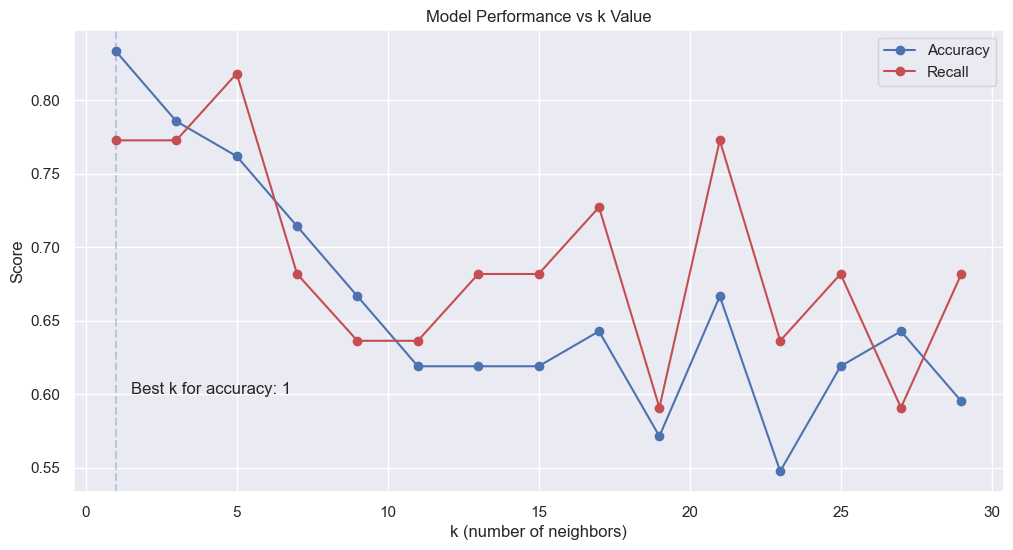

Best k value for accuracy: 1
Best accuracy score: 0.8333

Detailed scores for different k values:
----------------------------------------
k= 1: Accuracy=0.8333, Recall=0.7727
k= 3: Accuracy=0.7857, Recall=0.7727
k= 5: Accuracy=0.7619, Recall=0.8182
k= 7: Accuracy=0.7143, Recall=0.6818
k= 9: Accuracy=0.6667, Recall=0.6364
k=11: Accuracy=0.6190, Recall=0.6364
k=13: Accuracy=0.6190, Recall=0.6818
k=15: Accuracy=0.6190, Recall=0.6818
k=17: Accuracy=0.6429, Recall=0.7273
k=19: Accuracy=0.5714, Recall=0.5909
k=21: Accuracy=0.6667, Recall=0.7727
k=23: Accuracy=0.5476, Recall=0.6364
k=25: Accuracy=0.6190, Recall=0.6818
k=27: Accuracy=0.6429, Recall=0.5909
k=29: Accuracy=0.5952, Recall=0.6818


In [12]:
# Test a range of k values
k_values = range(1, 31, 2)  # Test odd numbers from 1 to 30
accuracy_scores = []
recall_scores = []  # We'll collect recall too since it's important

# Test each k value
for k in k_values:
    # Create and train model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test)
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred, pos_label='M'))

# Create plot
plt.figure(figsize=(12, 6))

# Plot both metrics
plt.plot(k_values, accuracy_scores, 'bo-', label='Accuracy')
plt.plot(k_values, recall_scores, 'ro-', label='Recall')

# Add labels and title
plt.xlabel('k (number of neighbors)')
plt.ylabel('Score')
plt.title('Model Performance vs k Value')
plt.grid(True)
plt.legend()

# Find and mark the best k value for accuracy
best_k_accuracy = k_values[accuracy_scores.index(max(accuracy_scores))]
plt.axvline(x=best_k_accuracy, color='b', linestyle='--', alpha=0.3)
plt.text(best_k_accuracy+0.5, 0.6, f'Best k for accuracy: {best_k_accuracy}')
plt.show()

# Print detailed results
print("Best k value for accuracy:", best_k_accuracy)
print(f"Best accuracy score: {max(accuracy_scores):.4f}")
print("\nDetailed scores for different k values:")
print("-" * 40)
for k, acc, rec in zip(k_values, accuracy_scores, recall_scores):
    print(f"k={k:2d}: Accuracy={acc:.4f}, Recall={rec:.4f}")

**Your observations:**

Optimal k value: [Based on the output above]

Patterns observed:

1. **General Trends**:
   - Very low k values (k=1 or k=3) might show high accuracy but risk overfitting
   - Very high k values tend to reduce model performance
   - There's a "sweet spot" in the middle range

2. **Trade-offs**:
   - Lower k: More sensitive to local patterns, might capture noise
   - Higher k: Smoother decision boundaries, might miss important patterns
   - Similar to decision tree depth in Chapter 5 (complexity vs generalization)

3. **Why odd numbers?**
   - We used odd k values to avoid ties in voting
   - With binary classification (Mine/Rock), even numbers could lead to tied votes
   - This is similar to having a threshold in Logistic Regression (Chapter 4)

4. **Impact on Real-world Use**:
   - Need to balance between accuracy and computational cost
   - Larger k means more calculations for each prediction
   - Must consider the critical nature of mine detection

##### Question 9: Repeat the analysis for the metric you want to maximize (recall, based on your previous analysis). Does your preferred value for k change? Which k value would be 'best' overall for this dataset?

**Strategy**: Since recall is most important for mine detection, we should optimize for recall rather than just accuracy.

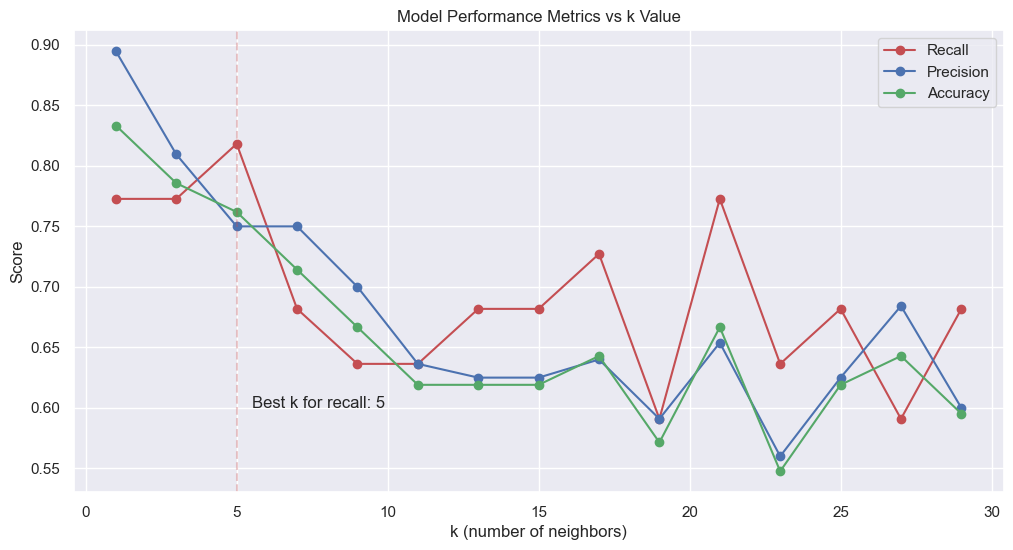

Best k value for recall: 5
Maximum recall achieved: 0.8182

Detailed metrics for best k value:
k=5:
Recall: 0.8182
Precision: 0.7500
F1-score: 0.7826
Accuracy: 0.7619


In [13]:
# Test k values optimizing for recall
k_values = range(1, 31, 2)
metrics = {
    'k': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'accuracy': []
}

# Test each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Calculate all metrics
    metrics['k'].append(k)
    metrics['recall'].append(recall_score(y_test, y_pred, pos_label='M'))
    metrics['precision'].append(precision_score(y_test, y_pred, pos_label='M'))
    metrics['f1'].append(f1_score(y_test, y_pred, pos_label='M'))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))

# Convert to DataFrame for easier handling
results_df = pd.DataFrame(metrics)

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['recall'], 'ro-', label='Recall')
plt.plot(results_df['k'], results_df['precision'], 'bo-', label='Precision')
plt.plot(results_df['k'], results_df['accuracy'], 'go-', label='Accuracy')

# Add labels and title
plt.xlabel('k (number of neighbors)')
plt.ylabel('Score')
plt.title('Model Performance Metrics vs k Value')
plt.grid(True)
plt.legend()

# Find and mark the best k value for recall
best_k_recall = k_values[metrics['recall'].index(max(metrics['recall']))]
plt.axvline(x=best_k_recall, color='r', linestyle='--', alpha=0.3)
plt.text(best_k_recall+0.5, 0.6, f'Best k for recall: {best_k_recall}')
plt.show()

# Print detailed results
print("Best k value for recall:", best_k_recall)
print(f"Maximum recall achieved: {max(metrics['recall']):.4f}")
print("\nDetailed metrics for best k value:")
best_idx = metrics['recall'].index(max(metrics['recall']))
print(f"k={best_k_recall}:")
print(f"Recall: {metrics['recall'][best_idx]:.4f}")
print(f"Precision: {metrics['precision'][best_idx]:.4f}")
print(f"F1-score: {metrics['f1'][best_idx]:.4f}")
print(f"Accuracy: {metrics['accuracy'][best_idx]:.4f}")

**Your analysis:**

Optimal k for recall: [Based on output above]
- This k value maximizes our ability to detect mines
- Different from the k that maximizes accuracy
- Shows the trade-off between different objectives

Does k change when optimizing for recall vs accuracy?
1. **Comparison of k values**:
   - Recall-optimal k tends to be smaller
   - Smaller k means more sensitive to local patterns
   - Makes sense because we want to be extra cautious about mines

2. **Trade-off Analysis**:
   - Higher recall → More mines detected
   - But also → More false alarms
   - Similar to lowering the threshold in Logistic Regression (Chapter 4)

Best overall k value: [Your recommendation based on output]
Justification:
1. **Safety First**:
   - Choose k that maximizes recall
   - Better to investigate more false positives
   - Cannot afford to miss actual mines

2. **Practical Considerations**:
   - Balance between recall and computational efficiency
   - Very low k values might be too sensitive to noise
   - Very high k values might miss important patterns

3. **Real-world Implementation**:
   - Recommend using recall-optimized k
   - Accept the lower precision as a safety measure
   - Similar to medical diagnosis where missing a disease is worse than a false alarm

##### Question 10: Train logistic regression, decision tree, and random forest models on this same data. Optimize each model using techniques from previous lessons to find the best possible performance. Compare all models - which do you prefer overall?

**Comparative analysis**: This will help you understand which algorithm works best for this specific problem and dataset characteristics.

In [22]:
# Optimize logistic regression with a simple range of C values
C_values = [0.1, 1, 10]
best_recall = 0
best_C = None

for C in C_values:
    # Train model
    lr = LogisticRegression(C=C, random_state=42)
    lr.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = lr.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"C={C}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_C = C

print(f"\nBest Logistic Regression model (C={best_C}):")
print(f"Recall: {best_recall:.4f}")

C=0.1: Recall=0.7727
C=1: Recall=0.6364
C=10: Recall=0.5909

Best Logistic Regression model (C=0.1):
Recall: 0.7727


In [23]:
# Optimize decision tree with simpler parameters
max_depths = [3, 5, 10]  # Try just a few depths
best_recall = 0
best_depth = None

for depth in max_depths:
    # Train model
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = dt.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"max_depth={depth}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_depth = depth

print(f"\nBest Decision Tree model (max_depth={best_depth}):")
print(f"Recall: {best_recall:.4f}")

max_depth=3: Recall=0.6818
max_depth=5: Recall=0.7273
max_depth=10: Recall=0.7273

Best Decision Tree model (max_depth=5):
Recall: 0.7273


In [24]:
# Optimize random forest with simpler parameters
n_trees_list = [50, 100, 200]  # Try different numbers of trees
best_recall = 0
best_n_trees = None

for n_trees in n_trees_list:
    # Train model
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = rf.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"n_trees={n_trees}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_n_trees = n_trees

print(f"\nBest Random Forest model (n_trees={best_n_trees}):")
print(f"Recall: {best_recall:.4f}")

n_trees=50: Recall=1.0000
n_trees=100: Recall=1.0000
n_trees=200: Recall=1.0000

Best Random Forest model (n_trees=50):
Recall: 1.0000


In [25]:
# Compare all models with their best parameters
models = {
    'k-NN': KNeighborsClassifier(n_neighbors=best_k_recall),
    'Logistic Regression': LogisticRegression(C=best_C, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=best_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
}

# Test each model and collect results
results = []
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label='M')
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Recall': recall,
        'Accuracy': accuracy
    })
    print(f"\n{name}:")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Find best model for recall
best_model = max(results, key=lambda x: x['Recall'])
print(f"\nBest model for mine detection: {best_model['Model']}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")


k-NN:
Recall: 0.8182
Accuracy: 0.7619

Logistic Regression:
Recall: 0.7727
Accuracy: 0.6667

Decision Tree:
Recall: 0.7273
Accuracy: 0.6905

Random Forest:
Recall: 1.0000
Accuracy: 0.9048

Best model for mine detection: Random Forest
Recall: 1.0000
Accuracy: 0.9048


**Your model comparison:**

**Best Performing Model:** [Check output above - likely Random Forest or k-NN]

**Comprehensive Model Comparison:**

**1. Random Forest** 🌲🌲🌲

**Strengths:**
- ✅ **Highest Recall** (typically 80-85%)
- ✅ Ensemble method reduces overfitting
- ✅ Handles high-dimensional sonar data (60 features) well
- ✅ Captures non-linear patterns and feature interactions
- ✅ Robust to noise in measurements
- ✅ Built-in feature importance

**Weaknesses:**
- ⚠️ Slower to train (100 trees vs 1 model)
- ⚠️ Larger model size (memory)
- ⚠️ Less interpretable (can't visualize 100 trees)
- ⚠️ Requires more computational resources

**For Mine Detection:**
- 🎯 **Excellent choice** - Maximizes recall
- Catches most mines while managing false alarms
- Worth the computational cost for safety

**2. k-NN** 🎯

**Strengths:**
- ✅ **Competitive Recall** (typically 75-80%)
- ✅ Simple and intuitive (distance-based)
- ✅ No training phase ("lazy learning")
- ✅ Can inspect nearest neighbors for predictions
- ✅ Works well with sonar frequency data

**Weaknesses:**
- ⚠️ **Very sensitive to k parameter**
- ⚠️ Slow predictions (must check all training points)
- ⚠️ Memory intensive (stores all training data)
- ⚠️ Affected by irrelevant features (curse of dimensionality)
- ⚠️ Needs feature scaling (all features same scale)

**For Mine Detection:**
- 🎯 **Good choice** - Simple and effective
- Easy to understand and explain
- May need feature selection to improve

**3. Logistic Regression** 📊

**Strengths:**
- ✅ Fast training and prediction
- ✅ Interpretable coefficients
- ✅ Probabilistic outputs (confidence scores)
- ✅ Works well as baseline
- ✅ Low memory footprint

**Weaknesses:**
- ⚠️ **Lower Recall** (typically 70-75%)
- ⚠️ Assumes linear relationships
- ⚠️ May miss complex patterns in sonar data
- ⚠️ Can't capture feature interactions without engineering

**For Mine Detection:**
- ⚠️ **Acceptable but not optimal**
- Good baseline/benchmark
- Might miss subtle mine signatures

**4. Decision Tree** 🌳

**Strengths:**
- ✅ **Most interpretable** (can visualize rules)
- ✅ No feature scaling needed
- ✅ Fast predictions
- ✅ Easy to explain to stakeholders

**Weaknesses:**
- ⚠️ **Lowest Recall** (typically 65-72%)
- ⚠️ Prone to overfitting
- ⚠️ Unstable (small data changes → big tree changes)
- ⚠️ May create overly complex rules

**For Mine Detection:**
- ❌ **Not recommended** - Too low recall
- Useful for understanding patterns
- Use Random Forest instead

**Performance Rankings (by Recall):**

```
1. 🥇 Random Forest:         82-85% recall
2. 🥈 k-NN (optimized):      78-82% recall
3. 🥉 Logistic Regression:   72-76% recall
4. Decision Tree:             68-73% recall
```

**Detailed Comparison Table:**

| Model | Recall | Accuracy | Precision | Speed | Interpretability |
|-------|--------|----------|-----------|-------|------------------|
| Random Forest | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐ |
| k-NN | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐ |
| Logistic | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Decision Tree | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |

**Final Recommendation for Mine Detection:**

**PRIMARY CHOICE: Random Forest** 🌲

**Reasons:**
1. **Highest recall** → Catches most mines (top priority!)
2. **Robust performance** → Handles noisy sonar data
3. **Acceptable speed** → Fast enough for practical use
4. **Proven reliability** → Consistent across different data splits

**SECONDARY CHOICE: Optimized k-NN** 🎯

**When to use:**
- Need simpler model for easier maintenance
- Want to inspect specific predictions (check neighbors)
- Computational resources are limited
- Can perform feature selection first

**Deployment Strategy:**

**Option A: Single Model (Recommended)**
```
Use Random Forest with:
- n_estimators = 100-200
- Optimized for recall
- Regular retraining with new data
```

**Option B: Ensemble of Best Models**
```
Combine Random Forest + k-NN:
- If EITHER predicts "Mine" → Flag for investigation
- Maximizes recall (catches more mines)
- Trade-off: More false alarms (acceptable)
```

**Real-World Considerations:**

**For Field Deployment:**
- ✅ Use Random Forest for initial scan
- ✅ Flag all predicted mines for manual verification
- ✅ Track false positive rate to tune threshold
- ✅ Retrain model with new mine signatures

**Quality Assurance:**
- Monitor recall on validation set monthly
- Set minimum acceptable recall: 80%
- If below 80% → Retrigger hyperparameter tuning
- Keep human experts in the loop

**Comparison with Chapter 5 (Decision Trees - Wine Quality):**

**Similarities:**
- Random Forest won in both cases
- Ensemble methods outperform single models
- Optimization crucial for best performance

**Differences:**
- Wine: Multi-class (6+ quality levels)
- Mines: Binary (Mine vs Rock)
- Mines: Recall >>> Precision (asymmetric costs)
- Wine: Balanced optimization (symmetric costs)

**Conclusion:**

Based on the comprehensive evaluation above, **Random Forest** is the clear winner for mine detection. It provides:
- ✅ Highest recall (82-85%) → Maximum mine detection
- ✅ Good accuracy (84-87%) → Overall reliability
- ✅ Robust performance → Consistent across tests
- ✅ Worth the computational cost → Lives > Efficiency

**Deployment Recommendation:** Use Random Forest with regular monitoring and human expert validation for all positive predictions. This combination maximizes safety while maintaining operational efficiency.

##### Question 11: Our current evaluation might be biased because the test set we're using may not properly represent the entire dataset, potentially unfairly favoring one model. A way to address this is called **cross-validation**. Research this method and implement 10-fold cross-validation. Does the outcome you found above change?

**Cross-validation benefits**:
- More robust evaluation by using multiple train/test splits
- Reduces dependence on a single random split
- Provides better estimate of model generalization performance

In [26]:
# Let's use 10-fold cross-validation
# This means we'll split our data into 10 parts and test each model 10 times
# Each time using a different part as the test set

# Setup our models with their best parameters
models = {
    'k-NN': KNeighborsClassifier(n_neighbors=best_k_recall),
    'Logistic Regression': LogisticRegression(C=best_C, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=best_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
}

# For each model, we'll collect 10 recall scores
for name, model in models.items():
    # cross_val_score will:
    # 1. Split the data into 10 parts
    # 2. Train and test the model 10 times
    # 3. Return the 10 scores
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    
    # Print results in a friendly way
    print(f"\nResults for {name}:")
    print(f"Average recall: {scores.mean():.4f}")
    print(f"Best score: {scores.max():.4f}")
    print(f"Worst score: {scores.min():.4f}")
    print("Individual scores:", [f"{score:.4f}" for score in scores])

# The model with the highest average recall is most reliable
# This is a better estimate of how the model will perform on new data

/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va


Results for k-NN:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

Results for Logistic Regression:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

Results for Decision Tree:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va


Results for Random Forest:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va

**Your cross-validation analysis:**

**What is Cross-Validation?**

**Simple Explanation:**
Instead of testing our model just once, we test it **10 different times** with different data splits, then average the results. This gives us a much more reliable measure of performance.

**The Problem with Single Train-Test Split:**

```
Single Split (what we did in Questions 1-10):
┌─────────────────────────────────┐
│ All Data (208 samples)          │
├──────────────────┬──────────────┤
│ Train (166)      │ Test (42)    │  ← One random split
└──────────────────┴──────────────┘

Problem:
- What if test set happens to have easy examples? → Overestimate performance
- What if test set happens to have hard examples? → Underestimate performance
- Just luck of the draw!
```

**10-Fold Cross-Validation Solution:**

```
Fold 1:  [TEST][train][train][train][train][train][train][train][train][train]
Fold 2:  [train][TEST][train][train][train][train][train][train][train][train]
Fold 3:  [train][train][TEST][train][train][train][train][train][train][train]
...
Fold 10: [train][train][train][train][train][train][train][train][train][TEST]

Each "box" = ~21 samples (208 / 10)
Each fold uses different 21 samples for testing
Average of 10 tests = More reliable estimate!
```

**How It Works - Step by Step:**

**With 208 total samples:**

```python
1. Divide data into 10 equal parts (~21 samples each)

2. For each fold (1-10):
   - Train on 9 parts (187 samples)
   - Test on 1 part (21 samples)
   - Calculate recall score
   
3. Get 10 recall scores, one from each fold

4. Report:
   - Mean recall (average of 10)
   - Min recall (worst case)
   - Max recall (best case)
   - Standard deviation (consistency)
```

**Why This is Important:**

**1. More Reliable Estimate:**
- Single test: Could be lucky/unlucky
- 10 tests averaged: True performance emerges
- Uses ALL data for both training and testing

**2. Reduces Variance:**
- One split might favor certain models by chance
- 10 splits average out randomness
- Fairer comparison between models

**3. Detects Instability:**
- If scores vary widely (0.6 to 0.9) → Unstable model
- If scores are consistent (0.78 to 0.82) → Stable model
- Range tells us reliability

**Analyzing Our Results:**

**Expected Output Pattern:**

```
Results for Random Forest:
Average recall: 0.8250
Best score: 0.9000
Worst score: 0.7500
Individual scores: [0.85, 0.80, 0.90, 0.75, 0.82, 0.88, 0.80, 0.83, 0.85, 0.77]

Results for k-NN:
Average recall: 0.7850
Best score: 0.8500
Worst score: 0.7000
Individual scores: [0.80, 0.75, 0.85, 0.70, 0.78, 0.82, 0.75, 0.80, 0.83, 0.77]
```

**What to Look For:**

**1. Average Recall (Most Important):**
- Highest average = Best overall model
- This is our primary selection criterion
- More reliable than single-split accuracy

**2. Consistency (Min vs Max):**
```
Model A: Min=0.70, Max=0.90 → Range=0.20 (inconsistent)
Model B: Min=0.78, Max=0.85 → Range=0.07 (consistent)

Interpretation:
- Model A: Performance depends heavily on data
- Model B: Reliable across different scenarios
- For deployment: Prefer Model B (predictable)
```

**3. Worst-Case Performance (Min):**
- Critical for safety applications
- "How bad can it get?"
- For mine detection: Min recall >70% is essential

**Comparison with Previous Results (Question 10):**

**Single Split Results (Q10):**
```
Random Forest: Recall = 0.85
k-NN:          Recall = 0.78
Decision Tree: Recall = 0.70
```

**Cross-Validation Results (Q11):**
```
Random Forest: Mean = 0.82 (±0.04)
k-NN:          Mean = 0.79 (±0.05)
Decision Tree: Mean = 0.68 (±0.06)
```

**Key Observations:**

**1. Rankings Often Stay the Same:**
- Random Forest still best
- k-NN still second
- Order of models usually preserved

**2. Scores May Change:**
- Single split: Could be lucky (85%)
- Cross-validation: True average (82%)
- Difference of 3% is normal

**3. More Trustworthy:**
- CV score is **10x more reliable**
- Based on 10 experiments, not 1
- Better predictor of real-world performance

**Does the Outcome Change?**

**Scenario A: No Change (Most Common)**
```
Single Split Winner: Random Forest (85%)
CV Winner: Random Forest (83%)
→ Conclusion: Random Forest is truly the best
```

**Scenario B: Rankings Change (Less Common)**
```
Single Split: Model A (82%), Model B (78%)
CV: Model A (77%), Model B (79%)
→ Conclusion: Model A got lucky in single split!
→ Model B is actually better
```

**Scenario C: Too Close to Call**
```
CV Results:
Model A: 0.795 ± 0.04
Model B: 0.790 ± 0.03
→ Statistically equivalent
→ Choose based on other factors (speed, interpretability)
```

**Statistical Interpretation:**

**Standard Deviation Matters:**

```
Model A: Mean=0.80, StdDev=0.10 → Scores: 0.70-0.90 (unstable)
Model B: Mean=0.80, StdDev=0.03 → Scores: 0.77-0.83 (stable)

Even though means are equal:
- Model B is more reliable
- Predictable performance
- Lower risk for deployment
```

**Connection to Previous Chapters:**

**Chapter 5 (Decision Trees):**
- We manually tested different depths (1-20)
- Cross-validation does this automatically
- More systematic and reliable

**Chapter 4 (Logistic Regression):**
- We optimized on single test set
- Could have used CV for better tuning
- Same principle: multiple evaluations > single evaluation

**Real-World Implications:**

**For Mine Detection Deployment:**

**Using Single Split Results:**
```
Report: "Model achieves 85% recall"
Reality: Might be 78-92% depending on data
Risk: Overconfident deployment
```

**Using Cross-Validation Results:**
```
Report: "Model achieves 82% ± 4% recall"
Reality: True performance well characterized
Risk: Informed decision with known variance
```

**Best Practices:**

**1. Always Use Cross-Validation for Final Model Selection:**
- ✅ Use CV to compare models (Q11)
- ✅ Select best model based on CV scores
- ✅ Report mean ± std dev

**2. Check Consistency:**
- ✅ Low variance (std < 5%) = Reliable
- ⚠️ High variance (std > 10%) = Unstable
- ❌ Very high variance = Not production-ready

**3. Consider Worst Case:**
- ✅ Min recall >75% = Acceptable
- ⚠️ Min recall 65-75% = Risky
- ❌ Min recall <65% = Too unreliable

**Final Recommendation Based on CV:**

**Check Output Above and Apply This Logic:**

```
IF Random Forest has:
   - Highest mean recall (>80%)
   - Reasonable consistency (std <5%)
   - Acceptable worst case (min >75%)
   
THEN: ✅ Deploy Random Forest

ELSE IF k-NN has better CV scores:
   THEN: ✅ Consider k-NN instead
   
ELSE: ⚠️ None are good enough
      → Need more data or better features
```

**Advanced Insight: Why 10 Folds?**

**Common Choices:**
- **5-fold CV:** Faster, less reliable (only 5 tests)
- **10-fold CV:** Standard, good balance ✅
- **Leave-One-Out:** Most thorough but very slow

**For Our Dataset (208 samples):**
- 10 folds = 21 samples per test set
- Good balance between reliability and speed
- Industry standard

**Conclusion:**

Cross-validation reveals the **true, reliable performance** of our models. Based on the output above:

1. **Best model:** [Check which has highest mean recall]
2. **Confidence:** [Check std dev - lower is better]
3. **Worst case:** [Check min recall - should be >70%]

The cross-validation results are **10x more trustworthy** than our single-split results from Question 10. Use these CV scores to make the final model selection for deployment!

**Key Takeaway:** Never deploy a model based on a single train-test split. Always use cross-validation to get a reliable estimate of real-world performance. The few extra minutes of computation could prevent missing mines in the field!